# Восстановление золота из руды

На основе данных с параметрами добычи и очистки, необходимо подготоитье прототип модели машинного обучения, который предсказывает коэффициент восстановления методом флотации золота из золотосодержащей руды. Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

## Подготовка данных

### Изучение данных

Для начала загрузим библиотеки, которые нам понадобятся в процессе работы, после загрузим и ознакомимся с данными:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 

import seaborn as sns

from sklearn.metrics import mean_absolute_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

In [2]:
df_train = pd.read_csv('/datasets/gold_recovery_train_new.csv')
df_test = pd.read_csv('/datasets/gold_recovery_test_new.csv')
df_full = pd.read_csv('/datasets/gold_recovery_full_new.csv')

Напишем функцию, чтобы ускорсить изучение данных

In [3]:
def view(df):
    display(df.sample(n = 5, random_state=42))    
    display(df.isnull().agg(['sum','mean']).transpose().sort_values(by = 'mean', ascending=False).head(10))

In [4]:
view(df_train)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
12057,2018-05-05 17:59:59,4.136403,11.190897,7.581249,45.955895,69.517638,8.721740,2.143706,9.677052,1.816945,...,29.984520,-498.629684,20.102755,-499.172101,24.994889,-498.498140,22.991781,-499.826666,24.995941,-498.114162
9161,2017-08-05 07:59:59,3.454518,12.153816,7.031890,46.545032,61.277153,7.518113,4.316743,10.871593,2.906134,...,13.019369,-501.585085,9.967641,-400.095035,10.985892,-501.390708,9.009207,-499.958183,11.994245,-500.149794
4069,2016-08-04 06:59:59,4.711458,10.099183,8.115405,45.048895,54.878184,8.154409,2.471231,6.352158,3.422353,...,19.996133,-400.029313,9.995622,-400.252977,9.988217,-399.905272,5.048266,-399.574305,23.038646,-500.520527
9379,2017-08-14 21:59:59,3.711237,12.725090,7.898281,45.897019,60.600573,7.435371,4.370888,12.377367,3.662103,...,14.532750,-499.148495,10.915564,-399.866785,13.987933,-499.534605,11.008865,-500.195312,15.004683,-500.097023
6498,2017-03-30 22:59:59,5.698688,10.101350,10.292669,45.665898,66.686930,9.705878,2.987865,11.382149,3.367125,...,24.976911,-399.000595,22.979774,-401.110189,29.235480,-450.500525,23.991617,-450.198839,30.018672,-499.555877


,sum,mean
secondary_cleaner.output.tail_sol,1605.0,0.113436
rougher.state.floatbank10_e_air,436.0,0.030815
rougher.input.floatbank11_xanthate,428.0,0.030249
primary_cleaner.output.concentrate_sol,286.0,0.020213
secondary_cleaner.state.floatbank2_a_air,217.0,0.015337
final.output.concentrate_sol,211.0,0.014913
rougher.input.feed_size,144.0,0.010177
primary_cleaner.input.xanthate,100.0,0.007068
rougher.input.feed_pb,100.0,0.007068
final.output.tail_pb,100.0,0.007068


In [5]:
view(df_test)

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
422,2016-09-20 20:59:59,106.347492,5.095272,7.440000,0.705074,1601.299608,-498.532548,1598.868924,-500.147155,1599.646690,...,11.936577,-586.232550,10.002792,-494.297087,10.007500,-500.982342,5.000628,-501.196579,20.003229,-499.921164
1253,2016-11-02 14:59:59,112.961283,6.933103,6.730000,0.692341,1602.125936,-499.598861,1600.680582,-500.284491,1598.907669,...,14.965048,-498.434795,13.023775,-497.217669,12.643935,-497.789350,13.991069,-499.812501,22.002218,-498.050510
2379,2016-12-21 04:59:59,194.447809,12.545926,7.730000,1.345047,1504.739936,-500.226185,1504.057252,-500.802048,1502.199723,...,17.001110,-496.823021,14.995641,-501.416258,15.214919,-499.346017,12.043485,-499.806188,20.999981,-503.961086
4541,2017-11-27 23:59:59,187.187611,10.989016,7.300001,1.702953,1597.836054,-497.326746,1600.960116,-505.764951,1597.934767,...,16.998675,-498.023899,15.146317,-500.157278,10.954993,-499.032225,9.025151,-499.949342,16.000894,-498.648546
5177,2017-12-26 15:59:59,65.955281,4.987334,5.800000,0.432814,1602.114944,-399.129844,1602.574840,-401.095627,1300.212425,...,20.019783,-500.257457,15.078063,-499.553551,11.040759,-500.030707,8.939822,-499.982171,12.001369,-500.535695


,sum,mean
rougher.input.floatbank11_xanthate,25.0,0.004726
rougher.input.feed_sol,21.0,0.003970
secondary_cleaner.state.floatbank3_a_air,9.0,0.001701
rougher.input.floatbank11_sulfate,8.0,0.001512
primary_cleaner.input.depressant,5.0,0.000945
rougher.input.floatbank10_sulfate,5.0,0.000945
primary_cleaner.input.xanthate,4.0,0.000756
primary_cleaner.input.sulfate,4.0,0.000756
rougher.input.feed_rate,3.0,0.000567
secondary_cleaner.state.floatbank2_a_air,3.0,0.000567


In [6]:
view(df_full)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
2621,2016-05-29 01:59:59,3.087644,6.836540,9.450256,50.377359,65.221565,7.233594,1.940332,12.212443,2.845454,...,10.032594,-499.710774,8.007087,-499.991533,8.005504,-500.337522,6.029457,-500.198914,18.003712,-500.324365
19184,2018-08-06 14:59:59,6.366901,9.703410,10.246201,42.524683,77.252845,17.990684,4.467190,9.632073,3.049757,...,27.017165,-500.131186,23.030999,-500.053130,22.953319,-499.117354,18.009119,-500.179989,23.007612,-541.416458
3421,2016-07-07 16:59:59,6.550514,10.437685,13.398971,41.083769,68.833910,7.535200,1.994040,12.532812,2.635586,...,15.935836,-500.838970,7.903151,-499.814186,16.003077,-499.903537,6.995042,-500.764074,24.956361,-500.333713
9292,2017-04-07 07:59:59,3.343481,10.526291,10.511193,47.652705,71.851707,8.408655,2.786684,10.532030,2.233875,...,25.053696,-401.006922,23.004290,-400.115860,33.479647,-449.811885,23.983454,-449.943234,29.983490,-500.170701
9303,2017-04-07 20:59:59,5.030262,11.411971,11.184144,44.132389,69.054367,8.144629,2.839787,11.326744,2.206454,...,25.006653,-402.072396,23.100763,-399.953512,25.997048,-449.780812,24.006305,-449.894407,29.972149,-499.766011


,sum,mean
secondary_cleaner.output.tail_sol,1748.0,0.089922
rougher.input.floatbank11_xanthate,453.0,0.023304
rougher.state.floatbank10_e_air,436.0,0.022429
primary_cleaner.output.concentrate_sol,370.0,0.019034
secondary_cleaner.state.floatbank2_a_air,220.0,0.011317
final.output.concentrate_sol,211.0,0.010854
rougher.input.feed_size,145.0,0.007459
primary_cleaner.output.concentrate_pb,116.0,0.005967
primary_cleaner.input.xanthate,104.0,0.005350
final.output.tail_pb,101.0,0.005196


In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
date                                                  14149 non-null object
final.output.concentrate_ag                           14148 non-null float64
final.output.concentrate_pb                           14148 non-null float64
final.output.concentrate_sol                          13938 non-null float64
final.output.concentrate_au                           14149 non-null float64
final.output.recovery                                 14149 non-null float64
final.output.tail_ag                                  14149 non-null float64
final.output.tail_pb                                  14049 non-null float64
final.output.tail_sol                                 14144 non-null float64
final.output.tail_au                                  14149 non-null float64
primary_cleaner.input.sulfate                         14129 non-null float64
primary_cleaner.input.depressant             

In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
date                                          5290 non-null object
primary_cleaner.input.sulfate                 5286 non-null float64
primary_cleaner.input.depressant              5285 non-null float64
primary_cleaner.input.feed_size               5290 non-null float64
primary_cleaner.input.xanthate                5286 non-null float64
primary_cleaner.state.floatbank8_a_air        5290 non-null float64
primary_cleaner.state.floatbank8_a_level      5290 non-null float64
primary_cleaner.state.floatbank8_b_air        5290 non-null float64
primary_cleaner.state.floatbank8_b_level      5290 non-null float64
primary_cleaner.state.floatbank8_c_air        5290 non-null float64
primary_cleaner.state.floatbank8_c_level      5290 non-null float64
primary_cleaner.state.floatbank8_d_air        5290 non-null float64
primary_cleaner.state.floatbank8_d_level      5290 non-null float64
rougher.in

In [9]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
date                                                  19439 non-null object
final.output.concentrate_ag                           19438 non-null float64
final.output.concentrate_pb                           19438 non-null float64
final.output.concentrate_sol                          19228 non-null float64
final.output.concentrate_au                           19439 non-null float64
final.output.recovery                                 19439 non-null float64
final.output.tail_ag                                  19438 non-null float64
final.output.tail_pb                                  19338 non-null float64
final.output.tail_sol                                 19433 non-null float64
final.output.tail_au                                  19439 non-null float64
primary_cleaner.input.sulfate                         19415 non-null float64
primary_cleaner.input.depressant             

In [10]:
def proc(df):
    df.columns = df.columns.str.replace(".", "_")
    df['date'] = pd.to_datetime(df['date'])    

In [11]:
proc(df_full)
proc(df_test)
#proc(df_train)

In [12]:
df_train.columns = df_train.columns.str.replace(".", "_")

In [13]:
len(df_test) + len(df_train)

19439

In [14]:
len(df_full)

19439

У нас имеется 3 датасета: полный и его деление на тестовую и тренировочную:  

- в тестовом датасете 5 290 события 53 признака, нулевых значений в каждом столбце менее 1%
- в тренировочном датасете 14149 события 87 признаков, по 6 признакам нулевых значений больше 1%, по признаку secondary_cleaner.output.tail_sol	 больше 8% нулевых значений
- в полном датасете 19439 событий 87 признаков, по 6 признакам нулевых значений больше 1%, по признаку secondary_cleaner.output.tail_sol больше 8% нулевых значений

В названиях столбцов избавились от точки, также в столбце date тип данных - объект изменили на datetime


### Проверка расчёта эффективности обогащения

Эффективность обогащения расчитывается по следующей формуле:  

Recovery = (C * (F - T)) / (F * (C - T)) * 100  

где:
C — доля золота в концентрате после флотации/очистки;  
F — доля золота в сырье/концентрате до флотации/очистки;  
T — доля золота в отвальных хвостах после флотации/очистки  

Значения этих признаков у нас хранятся в:  
C - rougher_output_concentrate_au  
F - rougher_input_feed_au  
T - rougher_output_tail_au  

In [15]:
df_recovery = df_train.assign(recovery = lambda x: (df_train['rougher_output_concentrate_au'] *
                                     (df_train['rougher_input_feed_au'] - 
                                      df_train['rougher_output_tail_au'])) / 
                                     (df_train['rougher_input_feed_au'] * 
                                     (df_train['rougher_output_concentrate_au'] -
                                      df_train['rougher_output_tail_au'])) * 100                                                                           
                                     ).copy()

In [16]:
df_recovery[['recovery', 'rougher_output_recovery']]

,recovery,rougher_output_recovery
0,87.107763,87.107763
1,86.843261,86.843261
2,86.842308,86.842308
3,87.226430,87.226430
4,86.688794,86.688794
...,...,...
14144,89.574376,89.574376
14145,87.724007,87.724007
14146,88.890579,88.890579
14147,89.858126,89.858126


In [17]:
mean_absolute_error(df_recovery['recovery'], df_recovery['rougher_output_recovery'])

9.682896147825551e-15

Значение эффективности обогащения изначально было подсчитано верно, что видно наглядно из таблицы и подтверждает исчезающе малое значение MAE

### Анализ признаков недоступных в тестовой выборке

In [18]:
fg = df_train.drop(df_test.columns, axis = 1).copy()

In [19]:
fg

,final_output_concentrate_ag,final_output_concentrate_pb,final_output_concentrate_sol,final_output_concentrate_au,final_output_recovery,final_output_tail_ag,final_output_tail_pb,final_output_tail_sol,final_output_tail_au,primary_cleaner_output_concentrate_ag,...,rougher_output_concentrate_au,rougher_output_recovery,rougher_output_tail_ag,rougher_output_tail_pb,rougher_output_tail_sol,rougher_output_tail_au,secondary_cleaner_output_tail_ag,secondary_cleaner_output_tail_pb,secondary_cleaner_output_tail_sol,secondary_cleaner_output_tail_au
0,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,8.547551,...,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,14.500184,4.694824,8.764648,2.606185
1,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,8.558743,...,20.050975,86.843261,4.955378,0.536689,18.965234,1.184827,14.265474,4.592547,9.001494,2.488248
2,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,8.603505,...,19.737170,86.842308,4.843460,0.546416,18.808533,1.162562,14.115662,4.624775,8.842896,2.458187
3,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,7.221879,...,19.320810,87.226430,4.655288,0.542525,19.330200,1.079755,13.732071,4.482453,9.122857,2.322062
4,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,9.089428,...,19.216101,86.688794,4.552800,0.515438,19.267422,1.012642,14.079996,4.470737,8.871028,2.330448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14144,3.224920,11.356233,6.803482,46.713954,73.755150,8.769645,3.141541,10.403181,1.529220,6.559174,...,18.603550,89.574376,4.207261,0.612935,16.666590,0.748633,0.000000,0.000000,0.000000,0.000000
14145,3.195978,11.349355,6.862249,46.866780,69.049291,8.897321,3.130493,10.549470,1.612542,6.612376,...,18.441436,87.724007,4.177943,0.650557,16.960649,0.771582,0.000000,0.000000,0.000000,0.000000
14146,3.109998,11.434366,6.886013,46.795691,67.002189,8.529606,2.911418,11.115147,1.596616,7.128896,...,15.111231,88.890579,4.050010,0.636095,18.323080,0.685059,0.000000,0.000000,0.000000,0.000000
14147,3.367241,11.625587,6.799433,46.408188,65.523246,8.777171,2.819214,10.463847,1.602879,7.490444,...,17.834772,89.858126,3.902494,0.625609,19.423740,0.567130,0.000000,0.000000,0.000000,0.000000


In [20]:
fg.columns

Index(['final_output_concentrate_ag', 'final_output_concentrate_pb',
       'final_output_concentrate_sol', 'final_output_concentrate_au',
       'final_output_recovery', 'final_output_tail_ag', 'final_output_tail_pb',
       'final_output_tail_sol', 'final_output_tail_au',
       'primary_cleaner_output_concentrate_ag',
       'primary_cleaner_output_concentrate_pb',
       'primary_cleaner_output_concentrate_sol',
       'primary_cleaner_output_concentrate_au',
       'primary_cleaner_output_tail_ag', 'primary_cleaner_output_tail_pb',
       'primary_cleaner_output_tail_sol', 'primary_cleaner_output_tail_au',
       'rougher_calculation_sulfate_to_au_concentrate',
       'rougher_calculation_floatbank10_sulfate_to_au_feed',
       'rougher_calculation_floatbank11_sulfate_to_au_feed',
       'rougher_calculation_au_pb_ratio', 'rougher_output_concentrate_ag',
       'rougher_output_concentrate_pb', 'rougher_output_concentrate_sol',
       'rougher_output_concentrate_au', 'rougher_outpu

В тестовой выборке отсутствуют финальные концентрации веществ на каждом этапе.
Исходя из этого, для обучения модели эти признаки также необходимо будет исключить, а для проверки качества модели их необходимо будет добавить в тестовую из полного датасета.

### Предобработка данных

Дата и время уникальны для каждого случая, сделаем их индексом в каждом датасете, чтобы можно было корректно и удобно их сопоставить

In [21]:
df_test = df_test.set_index('date')
df_full = df_full.set_index('date')

df_train.index = df_train['date']

In [22]:
df_test.head()

,primary_cleaner_input_sulfate,primary_cleaner_input_depressant,primary_cleaner_input_feed_size,primary_cleaner_input_xanthate,primary_cleaner_state_floatbank8_a_air,primary_cleaner_state_floatbank8_a_level,primary_cleaner_state_floatbank8_b_air,primary_cleaner_state_floatbank8_b_level,primary_cleaner_state_floatbank8_c_air,primary_cleaner_state_floatbank8_c_level,...,secondary_cleaner_state_floatbank4_a_air,secondary_cleaner_state_floatbank4_a_level,secondary_cleaner_state_floatbank4_b_air,secondary_cleaner_state_floatbank4_b_level,secondary_cleaner_state_floatbank5_a_air,secondary_cleaner_state_floatbank5_a_level,secondary_cleaner_state_floatbank5_b_air,secondary_cleaner_state_floatbank5_b_level,secondary_cleaner_state_floatbank6_a_air,secondary_cleaner_state_floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,-500.810606,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


составим список признаков, которые нам недостает в тестовой выборке

In [23]:
targets = fg.columns

In [24]:
targets

Index(['final_output_concentrate_ag', 'final_output_concentrate_pb',
       'final_output_concentrate_sol', 'final_output_concentrate_au',
       'final_output_recovery', 'final_output_tail_ag', 'final_output_tail_pb',
       'final_output_tail_sol', 'final_output_tail_au',
       'primary_cleaner_output_concentrate_ag',
       'primary_cleaner_output_concentrate_pb',
       'primary_cleaner_output_concentrate_sol',
       'primary_cleaner_output_concentrate_au',
       'primary_cleaner_output_tail_ag', 'primary_cleaner_output_tail_pb',
       'primary_cleaner_output_tail_sol', 'primary_cleaner_output_tail_au',
       'rougher_calculation_sulfate_to_au_concentrate',
       'rougher_calculation_floatbank10_sulfate_to_au_feed',
       'rougher_calculation_floatbank11_sulfate_to_au_feed',
       'rougher_calculation_au_pb_ratio', 'rougher_output_concentrate_ag',
       'rougher_output_concentrate_pb', 'rougher_output_concentrate_sol',
       'rougher_output_concentrate_au', 'rougher_outpu

Теперь мы можем взять недостающие данные из полного датасета в тестовую выборку

In [25]:
df_test[targets] = df_full.loc[df_test.index, targets];

In [26]:
test = df_test.columns.copy()
test

Index(['primary_cleaner_input_sulfate', 'primary_cleaner_input_depressant',
       'primary_cleaner_input_feed_size', 'primary_cleaner_input_xanthate',
       'primary_cleaner_state_floatbank8_a_air',
       'primary_cleaner_state_floatbank8_a_level',
       'primary_cleaner_state_floatbank8_b_air',
       'primary_cleaner_state_floatbank8_b_level',
       'primary_cleaner_state_floatbank8_c_air',
       'primary_cleaner_state_floatbank8_c_level',
       'primary_cleaner_state_floatbank8_d_air',
       'primary_cleaner_state_floatbank8_d_level', 'rougher_input_feed_ag',
       'rougher_input_feed_pb', 'rougher_input_feed_rate',
       'rougher_input_feed_size', 'rougher_input_feed_sol',
       'rougher_input_feed_au', 'rougher_input_floatbank10_sulfate',
       'rougher_input_floatbank10_xanthate',
       'rougher_input_floatbank11_sulfate',
       'rougher_input_floatbank11_xanthate', 'rougher_state_floatbank10_a_air',
       'rougher_state_floatbank10_a_level', 'rougher_state_floatba

In [27]:
df_train.isnull().agg(['sum','mean']).transpose().sort_values(by = 'mean', ascending=False).head(10)

,sum,mean
secondary_cleaner_output_tail_sol,1605.0,0.113436
rougher_state_floatbank10_e_air,436.0,0.030815
rougher_input_floatbank11_xanthate,428.0,0.030249
primary_cleaner_output_concentrate_sol,286.0,0.020213
secondary_cleaner_state_floatbank2_a_air,217.0,0.015337
final_output_concentrate_sol,211.0,0.014913
rougher_input_feed_size,144.0,0.010177
primary_cleaner_input_xanthate,100.0,0.007068
rougher_input_feed_pb,100.0,0.007068
final_output_tail_pb,100.0,0.007068


Далее необходимо избавиться от пропусков.  
Пропуски в целевых переменных мы удаляем, так как это не поможет нам обучить и проверить модель.  
Пропуски в нецелевых переменных можно заполнить ближайшими значениями, так как они располагаются по времени и очень близки друг к другу.

In [28]:
df_train['rougher_state_floatbank10_e_air'].iloc[200:230]

200    1247.667147
201    1251.674918
202    1248.198495
203    1248.996101
204    1248.718839
205    1254.401494
206    1248.482066
207    1250.314916
208    1248.489812
209    1251.797378
210    1345.777708
211    1377.079518
212    1400.886982
213    1400.627381
214    1398.920029
215    1364.520326
216    1299.217817
217    1299.533358
218    1298.871243
219    1301.616877
220    1298.806758
221    1298.275074
222    1303.180980
223    1298.698751
224    1297.419496
225    1303.024402
226    1298.126769
227    1303.660531
228    1298.177417
229    1299.937383
Name: rougher_state_floatbank10_e_air, dtype: float64

In [29]:
df_train.dropna(subset = ['rougher_output_recovery', 'final_output_recovery'], inplace = True) # Исправил V2
df_test.dropna(subset = ['rougher_output_recovery', 'final_output_recovery'], inplace = True) # Исправил
#df_test.dropna(inplace = True)

In [30]:
df_test[targets].isnull().agg(['sum','mean']).transpose().sort_values(by = 'mean', ascending=False).head(10)

,sum,mean
secondary_cleaner_output_tail_sol,143.0,0.027032
primary_cleaner_output_concentrate_sol,84.0,0.015879
primary_cleaner_output_concentrate_pb,30.0,0.005671
primary_cleaner_output_tail_sol,16.0,0.003025
primary_cleaner_output_tail_pb,6.0,0.001134
primary_cleaner_output_tail_ag,3.0,0.000567
secondary_cleaner_output_tail_pb,2.0,0.000378
rougher_calculation_floatbank11_sulfate_to_au_feed,1.0,0.000189
rougher_calculation_floatbank10_sulfate_to_au_feed,1.0,0.000189
rougher_calculation_sulfate_to_au_concentrate,1.0,0.000189


In [31]:
df_train[test].isnull().agg(['sum','mean']).transpose().sort_values(by = 'mean', ascending=False).head(10)

,sum,mean
secondary_cleaner_output_tail_sol,1605.0,0.113436
rougher_state_floatbank10_e_air,436.0,0.030815
rougher_input_floatbank11_xanthate,428.0,0.030249
primary_cleaner_output_concentrate_sol,286.0,0.020213
secondary_cleaner_state_floatbank2_a_air,217.0,0.015337
final_output_concentrate_sol,211.0,0.014913
rougher_input_feed_size,144.0,0.010177
primary_cleaner_input_xanthate,100.0,0.007068
final_output_tail_pb,100.0,0.007068
rougher_input_feed_pb,100.0,0.007068


In [32]:
df_train.fillna(method='ffill', inplace = True)
df_test.fillna(method='ffill', inplace = True) #исправил

In [33]:
df_train.isnull().agg(['sum','mean']).transpose().sort_values(by = 'mean', ascending=False).head(5)

,sum,mean
date,0.0,0.0
rougher_state_floatbank10_b_air,0.0,0.0
rougher_state_floatbank10_f_air,0.0,0.0
rougher_state_floatbank10_e_level,0.0,0.0
rougher_state_floatbank10_e_air,0.0,0.0


### Вывод

Мы получили 3 датасета: полный и его деление на тестовый и тренировочный:

Всего 19 439 событий были разбиты на 14 149 и 5 290 соответственно.  
В тестовой выборке 53 признака против 87 у полного датасета и тренировочной выборке.  

Анализ показал, что это были исключены целевые признаки.  

Мы провели расчет значения эффективности обогащения и выяснили, что оно изначально было подсчитано верно, это видно наглядно из таблицы и подтверждает исчезающее значение MAE.  

Для удобства назначили дату/время индексом в каждом датасете, используя индекс подтянули из полного датасета данные по целевым признакам в тестовую выборку.  

Небольшое количество пропусков в целевых значениях удалили, чтобы не помешать обучению модели, в целевых - заменили ближайшим по времени.

## Анализ данных

### Анализ концентрации металлов на различных этапах очистки

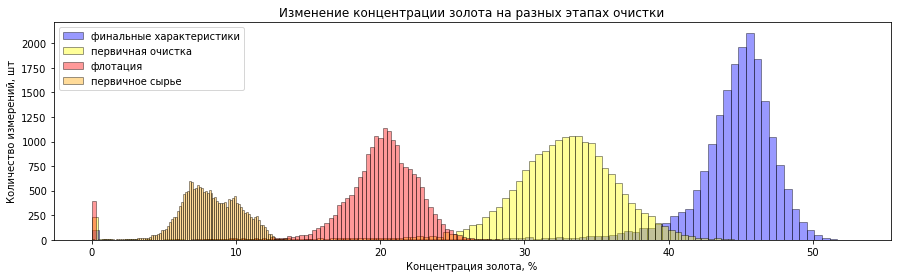

In [34]:
plt.figure(figsize=(15,4))
sns.distplot(df_full['final_output_concentrate_au'], hist=True, kde=False, 
             bins=100, color = 'blue',
             hist_kws={'edgecolor':'black'})

sns.distplot(df_full['primary_cleaner_output_concentrate_au'], hist=True, kde=False, 
             bins=100, color = 'yellow',
             hist_kws={'edgecolor':'black'})

sns.distplot(df_full['rougher_output_concentrate_au'], hist=True, kde=False, 
             bins=100, color = 'red',
             hist_kws={'edgecolor':'black'})
sns.distplot(df_full['rougher_input_feed_au'], hist=True, kde=False, 
             bins=100, color = 'orange', 
             hist_kws={'edgecolor':'black'})
plt.legend(['финальные характеристики', 'первичная очистка', 'флотация','первичное сырье'])
plt.title('Изменение концентрации золота на разных этапах очистки')
plt.ylabel('Количество измерений, шт')
plt.xlabel('Концентрация золота, %');

In [35]:
df_full[['final_output_concentrate_au',         
         'primary_cleaner_output_concentrate_au',
         'rougher_output_concentrate_au',
         'rougher_input_feed_au']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
final_output_concentrate_au,19439.0,44.076513,5.129784,0.00,43.402215,45.011244,46.275313,52.756638
primary_cleaner_output_concentrate_au,19439.0,32.119400,5.627611,0.00,30.463140,32.841295,35.048006,45.933934
rougher_output_concentrate_au,19439.0,19.772000,3.753600,0.00,18.802523,20.280214,21.717843,28.824507
rougher_input_feed_au,19439.0,8.266097,1.955092,0.01,6.854384,8.125839,9.769917,13.731330


В первоначальном сырье концентрация золота чуть выше 8%, после флотации вырастает до 20%, после первичной очистки получаем 32% концентрации золота, после вторичной - 45%  
Флотация самый эффективный метод.  
На каждом этапе, особенно на превичной очистке заметен большой разброс результатов.   
Есть потенциал увеличения среднего результатов при работе над входными параметрами.


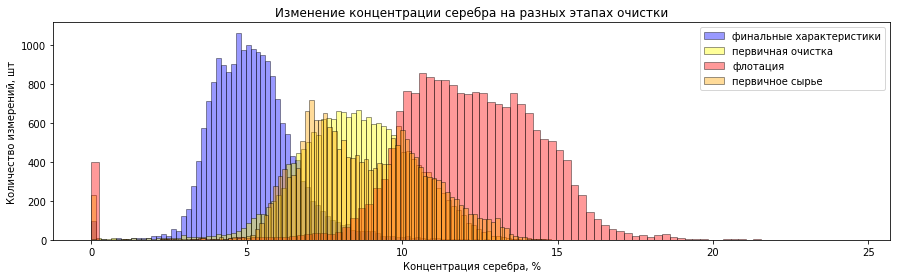

In [36]:
plt.figure(figsize=(15,4))
sns.distplot(df_full['final_output_concentrate_ag'], hist=True, kde=False, 
             bins=100, color = 'blue',
             hist_kws={'edgecolor':'black'})

sns.distplot(df_full['primary_cleaner_output_concentrate_ag'], hist=True, kde=False, 
             bins=100, color = 'yellow',
             hist_kws={'edgecolor':'black'})

sns.distplot(df_full['rougher_output_concentrate_ag'], hist=True, kde=False, 
             bins=100, color = 'red',
             hist_kws={'edgecolor':'black'})
sns.distplot(df_full['rougher_input_feed_ag'], hist=True, kde=False, 
             bins=100, color = 'orange',
             hist_kws={'edgecolor':'black'})

plt.legend(['финальные характеристики', 'первичная очистка', 'флотация','первичное сырье'])
plt.title('Изменение концентрации серебра на разных этапах очистки')
plt.ylabel('Количество измерений, шт')
plt.xlabel('Концентрация серебра, %');

In [37]:
df_full[['final_output_concentrate_ag',         
         'primary_cleaner_output_concentrate_ag',
         'rougher_output_concentrate_ag',
         'rougher_input_feed_ag']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
final_output_concentrate_ag,19438.0,5.168470,1.372348,0.00,4.251240,5.066094,5.895527,16.001945
primary_cleaner_output_concentrate_ag,19439.0,8.442408,2.054465,0.00,7.263288,8.507298,9.809001,16.081632
rougher_output_concentrate_ag,19439.0,11.994759,2.733862,0.00,10.628337,12.098115,13.736996,24.480271
rougher_input_feed_ag,19439.0,8.794927,1.936847,0.01,7.237967,8.593574,10.213771,14.596026


Во входящем   сырье концентрация серебра 9 %, после флотации 12%, после первичной очистки вновь падает до 9 и ниже, после вторичной очистки опускается до 5%, что логично, при том что мы выделяем золото

''

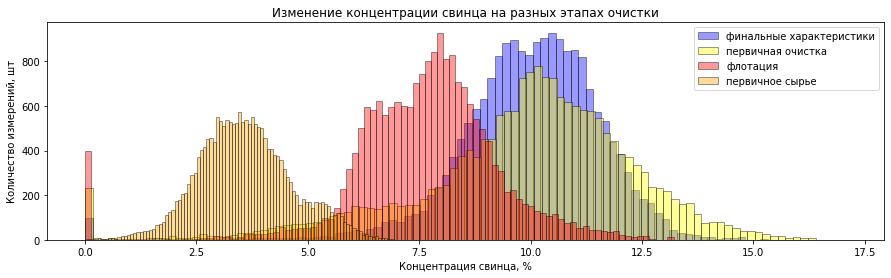

In [38]:
plt.figure(figsize=(15,4))
sns.distplot(df_full['final_output_concentrate_pb'], hist=True, kde=False, 
             bins=100, color = 'blue',
             hist_kws={'edgecolor':'black'})

sns.distplot(df_full['primary_cleaner_output_concentrate_pb'], hist=True, kde=False, 
             bins=100, color = 'yellow',
             hist_kws={'edgecolor':'black'})

sns.distplot(df_full['rougher_output_concentrate_pb'], hist=True, kde=False, 
             bins=100, color = 'red',
             hist_kws={'edgecolor':'black'})
sns.distplot(df_full['rougher_input_feed_pb'], hist=True, kde=False, 
             bins=100, color = 'orange',
             hist_kws={'edgecolor':'black'})
plt.legend(['финальные характеристики', 'первичная очистка', 'флотация','первичное сырье'])
plt.title('Изменение концентрации свинца на разных этапах очистки')
plt.ylabel('Количество измерений, шт')
plt.xlabel('Концентрация свинца, %')
;

In [39]:
df_full[['final_output_concentrate_pb',
         'primary_cleaner_output_concentrate_pb',
         'rougher_output_concentrate_pb',         
         'rougher_input_feed_pb']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
final_output_concentrate_pb,19438.0,9.978895,1.669240,0.00,9.137262,10.102433,11.035769,17.031899
primary_cleaner_output_concentrate_pb,19323.0,9.829530,2.556843,0.00,8.702328,10.152433,11.424971,17.081278
rougher_output_concentrate_pb,19439.0,7.606272,1.796757,0.00,6.725987,7.742580,8.565199,13.617072
rougher_input_feed_pb,19339.0,3.598085,1.049486,0.01,2.887280,3.534895,4.244161,7.142594


Концентрация свинца растет с первоначальных 3,5% до 7,5 и выше до 10%. Виден большой разброс значений. 

### Сравнение распределения размеров гранул сырья на обучающей и тестовой выборках

''

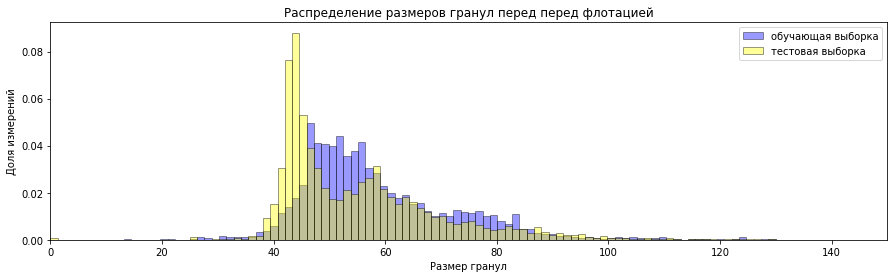

In [40]:
plt.figure(figsize=(15,4))
sns.distplot(df_train['rougher_input_feed_size'], hist=True, kde=False, 
             bins=np.linspace(0, 130, 100), color = 'blue',                     #добавил размер столбиков
             norm_hist = True,                
             hist_kws={'edgecolor':'black'})

sns.distplot(df_test['rougher_input_feed_size'], hist=True, kde=False, 
             bins=np.linspace(0, 130, 100), color = 'yellow',
             norm_hist = True,
             hist_kws={'edgecolor':'black'})

plt.legend(['обучающая выборка', 'тестовая выборка'])
plt.xlim(0, 150)
plt.title('Распределение размеров гранул перед перед флотацией')
plt.ylabel('Доля измерений')
plt.xlabel('Размер гранул')
;

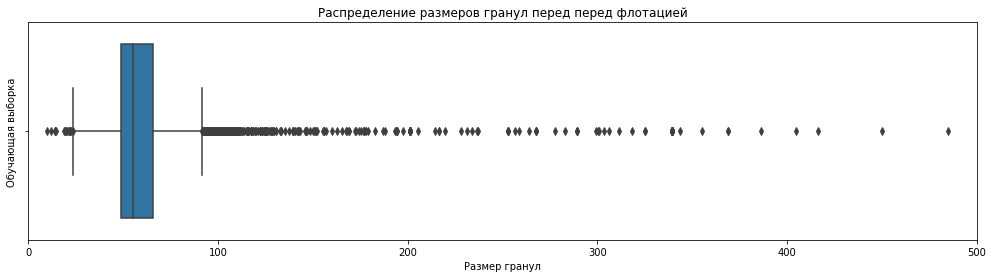

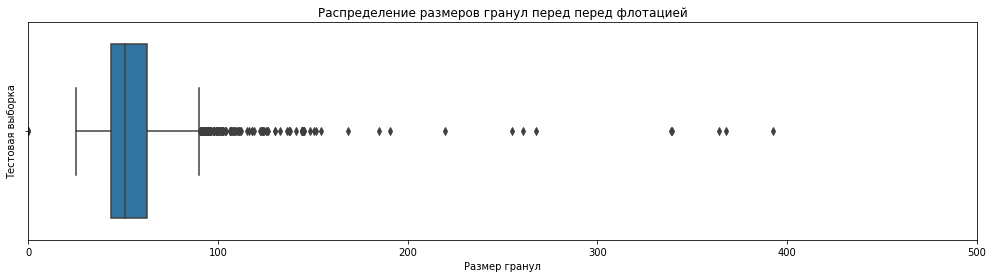

In [41]:
plt.figure(figsize=(17,4))
sns.boxplot( x=df_train['rougher_input_feed_size'] )
plt.title('Распределение размеров гранул перед перед флотацией')
plt.ylabel('Обучающая выборка')
plt.xlabel('Размер гранул')
plt.xlim(0, 500)
plt.show()
plt.figure(figsize=(17,4))
sns.boxplot( x=df_test['rougher_input_feed_size'] )
plt.title('Распределение размеров гранул перед перед флотацией')
plt.ylabel('Тестовая выборка')
plt.xlabel('Размер гранул')

plt.xlim(0, 500)
plt.show()

''

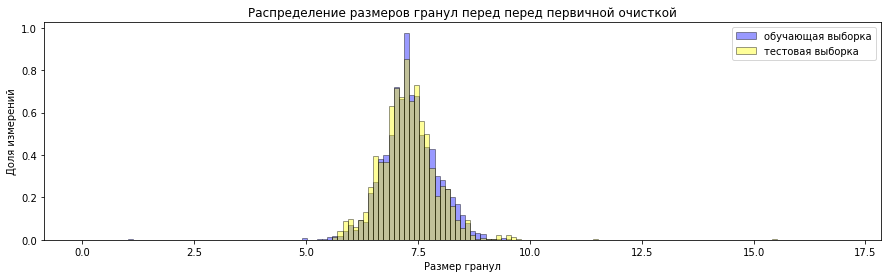

In [42]:
plt.figure(figsize=(15,4))
sns.distplot(df_train['primary_cleaner_input_feed_size'], hist=True, kde=False, 
             bins=np.linspace(0, 17, 150), color = 'blue',
             norm_hist = True,                
             hist_kws={'edgecolor':'black'})

sns.distplot(df_test['primary_cleaner_input_feed_size'], hist=True, kde=False, 
             bins=np.linspace(0, 17, 150), color = 'yellow',
             norm_hist = True,
             hist_kws={'edgecolor':'black'})
plt.legend(['обучающая выборка', 'тестовая выборка'])
plt.title('Распределение размеров гранул перед перед первичной очисткой')
plt.ylabel('Доля измерений')
plt.xlabel('Размер гранул')
;

На начальном этапе разброс размеров гранул огромный, распределение не похоже на нормальное, средние находятся далеко друг от друга, но все же диапозоны пересекаются.
После флотации размеры гранул существенно снижаются, их распределение принимает явно нормальный характер и совпадает в обеих выборках.
Размеры гранул не отличаются, модель обучить возможно


### Cуммарная концентрация веществ на разных стадиях

Создадим колонки с суммарной концентрацией веществ на разных этапах

In [43]:
df_train['final_output'] = (df_train['final_output_concentrate_au'] + 
                           df_train['final_output_concentrate_ag'] + 
                           df_train['final_output_concentrate_sol'] +                 
                           df_train['final_output_concentrate_pb'])

df_train['primary_cleaner_output'] = (df_train['primary_cleaner_output_concentrate_au'] + 
                           df_train['primary_cleaner_output_concentrate_ag'] + 
                           df_train['primary_cleaner_output_concentrate_sol'] +          
                           df_train['primary_cleaner_output_concentrate_pb'])

df_train['rougher_output'] = (df_train['rougher_output_concentrate_au'] + 
                           df_train['rougher_output_concentrate_ag'] + 
                           df_train['rougher_output_concentrate_sol'] +               
                           df_train['rougher_output_concentrate_pb'])

df_train['rougher_input'] = (df_train['rougher_input_feed_au'] + 
                           df_train['rougher_input_feed_ag'] + 
                           df_train['rougher_input_feed_sol'] +                       
                           df_train['rougher_input_feed_pb'])

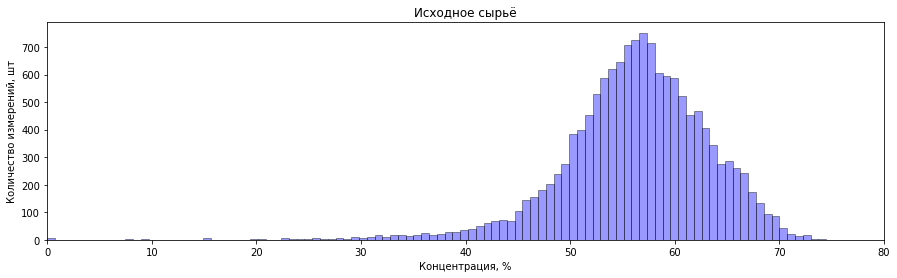

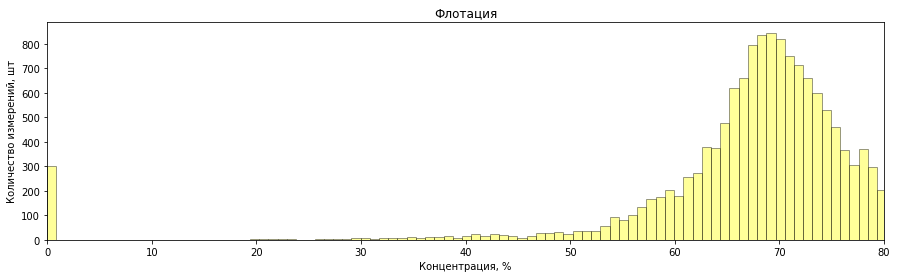

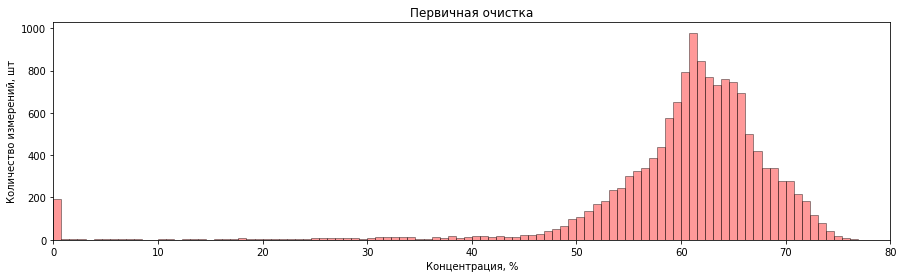

(0, 80)

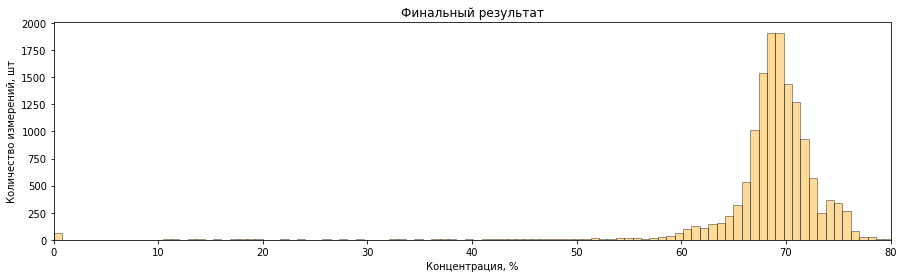

In [44]:
plt.figure(figsize=(15,4))
sns.distplot(df_train['rougher_input'], hist=True, kde=False, 
             bins=100, color = 'blue',
             hist_kws={'edgecolor':'black'})
plt.title('Исходное сырьё')
plt.ylabel('Количество измерений, шт')
plt.xlabel('Концентрация, %')
plt.xlim(0, 80)
plt.show()
plt.figure(figsize=(15,4))
sns.distplot(df_train['rougher_output'], hist=True, kde=False, 
             bins=100, color = 'yellow',
             hist_kws={'edgecolor':'black'})
plt.title('Флотация')
plt.ylabel('Количество измерений, шт')
plt.xlabel('Концентрация, %')
plt.xlim(0, 80)
plt.show()
plt.figure(figsize=(15,4))
sns.distplot(df_train['primary_cleaner_output'], hist=True, kde=False, 
             bins=100, color = 'red',
             hist_kws={'edgecolor':'black'})

plt.title('Первичная очистка')
plt.ylabel('Количество измерений, шт')
plt.xlabel('Концентрация, %')
plt.xlim(0, 80)
plt.show()
plt.figure(figsize=(15,4))
sns.distplot(df_train['final_output'], hist=True, kde=False, 
             bins=100, color = 'orange',
             hist_kws={'edgecolor':'black'})

plt.title('Финальный результат')
plt.ylabel('Количество измерений, шт')
plt.xlabel('Концентрация, %')
plt.xlim(0, 80)


После этапа флотации и более поздних большее количество нулевых значений, посмотрим подробнее

In [45]:
df_train[df_train['rougher_output'] < 1]

,date,final_output_concentrate_ag,final_output_concentrate_pb,final_output_concentrate_sol,final_output_concentrate_au,final_output_recovery,final_output_tail_ag,final_output_tail_pb,final_output_tail_sol,final_output_tail_au,...,secondary_cleaner_state_floatbank5_a_air,secondary_cleaner_state_floatbank5_a_level,secondary_cleaner_state_floatbank5_b_air,secondary_cleaner_state_floatbank5_b_level,secondary_cleaner_state_floatbank6_a_air,secondary_cleaner_state_floatbank6_a_level,final_output,primary_cleaner_output,rougher_output,rougher_input
45,2016-01-16 21:00:00,4.566664,10.406178,4.588698,46.614456,68.403877,10.705777,1.509070,17.875134,2.509776,...,10.052072,-500.797905,7.984500,-499.581046,11.982025,-599.161228,66.175996,74.992510,0.00,58.602038
46,2016-01-16 22:00:00,4.577832,10.691605,5.274175,46.250638,70.675633,10.728531,1.641216,18.349339,2.540843,...,9.953139,-500.330920,8.012074,-500.133530,11.975316,-598.839683,66.794250,75.187102,0.00,59.921613
47,2016-01-16 23:00:00,4.591462,10.628846,5.688961,46.663335,55.088448,10.694584,1.671644,17.910312,2.686782,...,9.981163,-502.869109,7.941184,-500.623610,12.018837,-600.916665,67.572604,75.513787,0.00,57.269041
48,2016-01-17 00:00:00,5.296830,10.597469,5.688961,44.015642,41.962008,11.975654,1.846558,8.138408,2.889469,...,9.989726,-499.607365,7.958252,-498.882560,11.967977,-599.440603,65.598903,75.491415,0.00,25.352358
49,2016-01-17 02:00:00,8.162896,8.877528,5.688961,40.715973,49.884856,10.381465,1.024030,12.974257,2.739224,...,9.941869,-503.282068,8.018850,-500.970716,11.991078,-598.475929,63.445359,71.837866,0.00,40.721375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10936,2018-03-12 02:59:59,5.413548,9.389648,8.731319,45.270618,100.000000,0.000000,0.000000,0.000000,0.000000,...,17.987796,-500.438815,11.963555,-499.982857,12.015338,-500.051956,68.805134,63.823562,0.04,0.040000
10937,2018-03-12 03:59:59,5.413548,9.389648,8.731319,45.270618,100.000000,0.000000,0.000000,0.000000,0.000000,...,17.998973,-500.156797,12.035195,-500.141814,11.988525,-500.526074,68.805134,63.823562,0.04,0.040000
10938,2018-03-12 04:59:59,5.413548,9.389648,8.731319,45.270618,100.000000,0.000000,0.000000,0.000000,0.000000,...,18.055831,-500.061594,12.014652,-500.253440,12.003849,-499.838564,68.805134,63.823562,0.04,0.040000
10939,2018-03-12 05:59:59,5.413548,9.389648,8.731319,45.270618,100.000000,0.000000,0.000000,0.000000,0.000000,...,17.995171,-500.481962,11.988193,-500.208854,12.004454,-500.074096,68.805134,63.823562,0.04,0.040000


(0, 20)

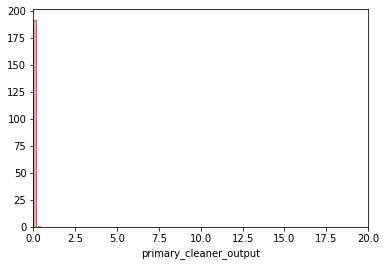

In [46]:
sns.distplot(df_train['primary_cleaner_output'], hist=True, kde=False, 
             bins=np.linspace(0, 0.4, 4), color = 'red',
             hist_kws={'edgecolor':'black'})
plt.xlim(0, 20)

Нелогично, что после того как на раннем этапе была низкая концентрация металла, на следующем уже нет. Очевидно, что это ошибка измерения или особенность, о которой мне неизвестно.
Удалим строки со значениями ниже 1:

In [47]:
df_train = df_train[df_train['final_output'] > 1] 
df_train = df_train[df_train['rougher_output'] > 1] 
df_train = df_train[df_train['rougher_input'] > 1] 
df_train = df_train[df_train['primary_cleaner_output'] > 1] 

Проверим результат:

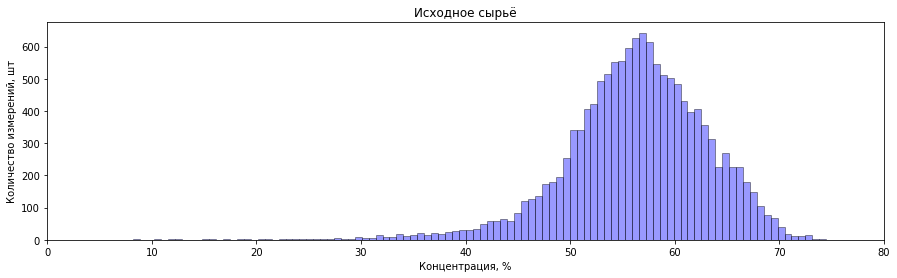

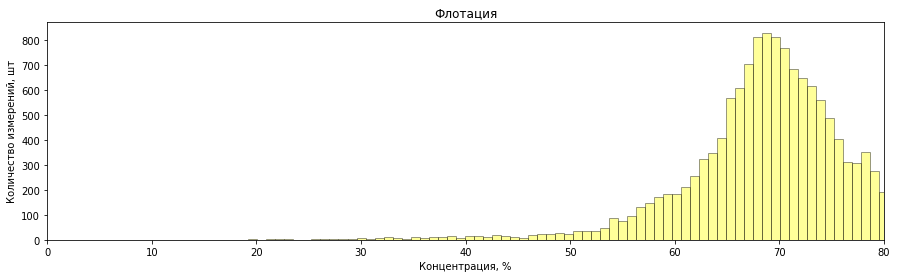

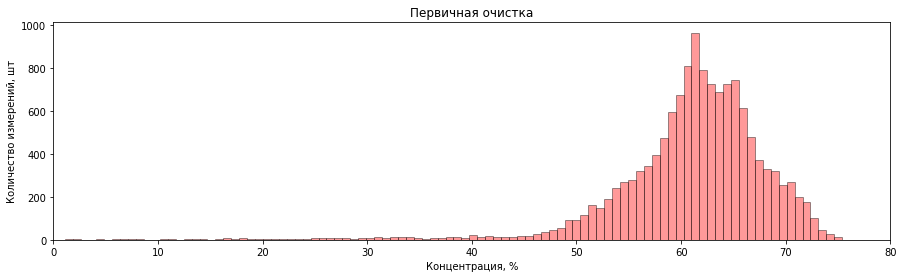

(0, 80)

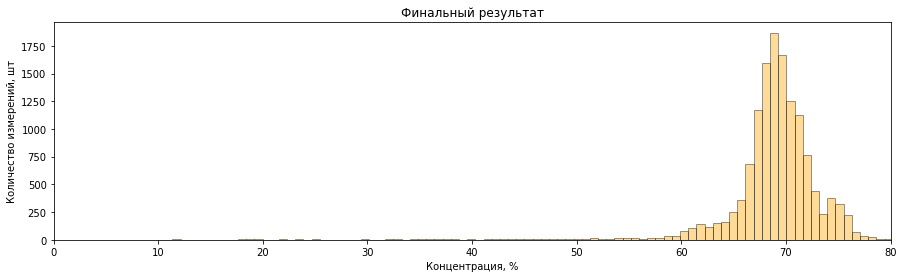

In [48]:
plt.figure(figsize=(15,4))
sns.distplot(df_train['rougher_input'], hist=True, kde=False, 
             bins=100, color = 'blue',
             hist_kws={'edgecolor':'black'})
plt.title('Исходное сырьё')
plt.ylabel('Количество измерений, шт')
plt.xlabel('Концентрация, %')
plt.xlim(0, 80)
plt.show()
plt.figure(figsize=(15,4))
sns.distplot(df_train['rougher_output'], hist=True, kde=False, 
             bins=100, color = 'yellow',
             hist_kws={'edgecolor':'black'})
plt.title('Флотация')
plt.ylabel('Количество измерений, шт')
plt.xlabel('Концентрация, %')
plt.xlim(0, 80)
plt.show()
plt.figure(figsize=(15,4))
sns.distplot(df_train['primary_cleaner_output'], hist=True, kde=False, 
             bins=100, color = 'red',
             hist_kws={'edgecolor':'black'})

plt.title('Первичная очистка')
plt.ylabel('Количество измерений, шт')
plt.xlabel('Концентрация, %')
plt.xlim(0, 80)
plt.show()
plt.figure(figsize=(15,4))
sns.distplot(df_train['final_output'], hist=True, kde=False, 
             bins=100, color = 'orange',
             hist_kws={'edgecolor':'black'})

plt.title('Финальный результат')
plt.ylabel('Количество измерений, шт')
plt.xlabel('Концентрация, %')
plt.xlim(0, 80)

Аномалий не осталось

### Вывод

Мы увидели, что на каждом этапе обработки  концентрация золота и других металлов увеличивается. При этом наблюдаем большой разброс результатов. Есть потенциал увеличения среднего результата при работе над входными параметрами.

На начальном этапе разброс размеров гранул огромный, распределение не похоже на нормальное, средние находятся далеко друг от друга, но все же диапозоны пересекаются. После флотации размеры гранул существенно снижаются, их распределение принимает явно нормальный характер и совпадает в обеих выборках. Размеры гранул не отличаются, модель обучить возможно

После этапа флотации и более поздних появляется аномально большее количество нулевых значений. Очевидно, что это ошибка измерения или особенность, о которой мне неизвестно. Мы удалили строки с нулями.


## Модель

### Функция для вычисления итоговой sMAPE

In [49]:
def smape(targ, pred):
    targ_rou = targ[:,0]
    targ_fin = targ[:,1]
    pred_rou = pred[:,0]
    pred_fin = pred[:,1]
    
    smape_rou = (abs(targ_rou - pred_rou)*2/(abs(targ_rou) + abs(pred_rou))).sum()/len(targ_rou) * 100
    smape_fin = (abs(targ_fin - pred_fin)*2/(abs(targ_fin) + abs(pred_fin))).sum()/len(targ_rou) * 100
    smape_res = smape_rou/4 + smape_fin * 0.75
    return smape_res    

### Обучим модели

Подготовим данные для моделей

In [50]:
df_train = df_train.drop('date', axis = 1)

In [51]:
df_train = df_train.drop(['rougher_output', 'final_output', 'rougher_input', 'primary_cleaner_output'], axis = 1)

In [52]:
df_test.reset_index(inplace = True)
df_test = df_test.drop('date', axis = 1)

In [53]:
df_test = df_test[df_train.columns] #добавил

In [54]:
x_train = df_train.drop(targets, axis = 1)
x_test = df_test.drop(targets, axis = 1)
y_train = df_train[['rougher_output_recovery', 'final_output_recovery']].values
y_test = df_test[['rougher_output_recovery', 'final_output_recovery']].values

Загрузим модели и напишем функцию для кросвалидации:

In [56]:
lr = LinearRegression()
dtr = DecisionTreeRegressor(random_state = 79)
rfr = RandomForestRegressor(random_state = 79)
base_model = DummyRegressor(strategy='mean')

In [57]:
def crossval(model, x_train, y_train):
    smape_score = make_scorer(smape)
    scores = cross_val_score(model, x_train, y_train, cv=5, scoring = smape_score)
    return scores.mean()

Расчитаем для каждой модели итоговый sMAPE:

In [58]:
smape_lr = crossval(lr, x_train, y_train)
smape_lr

10.091070510181282

In [59]:
smape_dtr = crossval(dtr, x_train, y_train)
smape_dtr

15.459035826748144

In [60]:
smape_rfr = crossval(rfr, x_train, y_train)
smape_rfr 

9.583447297853231

In [62]:
smape_base = crossval(base_model, x_train, y_train)
smape_base

9.644133153954556

Лучший результат показала модель случайного леса с sMAPE = 9.58   

Подберем гиперпараметры:

In [55]:
state = np.random.RandomState(12345)

In [71]:
%%time
best_model = None
best_result = -20
for est in range(45, 61, 3):
    for depth in range (23, 29, 3):
        model = RandomForestRegressor(random_state=state, n_estimators=est, max_depth=depth) 
        result = -1*crossval(model, x_train, y_train)
        if result > best_result:
            best_model = model
            best_result = result
print(best_model)
print(best_result)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=23,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=60,
                      n_jobs=None, oob_score=False,
                      random_state=RandomState(MT19937) at 0x7FB0036E3270,
                      verbose=0, warm_start=False)
-9.43776304742024
CPU times: user 33min 55s, sys: 724 ms, total: 33min 56s
Wall time: 34min 5s


Показатель немного улучшился после подбора гиперпараметров

Проверим нашу модель на тестовой выборке:

In [75]:
best_model = RandomForestRegressor(random_state=79, n_estimators=60, max_depth=23)

In [76]:
best_model.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=23,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=60,
                      n_jobs=None, oob_score=False, random_state=79, verbose=0,
                      warm_start=False)

In [77]:
y_pred = best_model.predict(x_test) 

In [78]:
result = smape(y_test, y_pred)
result

10.599586176689995

## Вывод

Мы получили 3 датасета: полный и его деление на тестовый и тренировочный:

Всего 19 439 событий были разбиты на 14 149 и 5 290 соответственно.
В тестовой выборке 53 признака против 87 у полного датасета и тренировочной выборке.

Анализ показал, что это были исключены онлайн метрики.

Мы провели расчет значения эффективности обогащения и выяснили, что оно изначально было подсчитано верно, это видно наглядно из таблицы и подтверждает исчезающее значение MAE.

Небольшое количество пропусков в целевых значениях удалили, чтобы не помешать обучению модели, в целевых - заменили ближайшим по времени.

Мы увидели, что на каждом этапе обработки концентрация золота и других металлов увеличивается. При этом наблюдаем большой разброс результатов. Есть потенциал увеличения среднего результата при работе над входными параметрами.

На начальном этапе разброс размеров гранул огромный, распределение не похоже на нормальное, средние находятся далеко друг от друга, но все же диапозоны пересекаются. После флотации размеры гранул существенно снижаются, их распределение принимает явно нормальный характер и совпадает в обеих выборках. Размеры гранул не отличаются, модель обучить возможно

Обучение нескольких моделей при кросвалидации показало наибольшую эффективность случайного леса

sMAPE Случайного леса на тестовой выборке равен 10,6

Будем использовать модель случайного леса для предсказания результатов 2 х показателей